# DDoS attacks detection and characterization

First, we need to import the necessary libraries.

In [6]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

# To display all the columns while printing dataframes
pd.set_option('display.max_columns', None)

## Clusters explainability and analysis
Now, we load the preprocessed dataset already used for the unsupervised learning phase.

In [7]:
# Load the dataset
df = pd.read_csv("preprocessed_dataset.csv", header=0, index_col=0, engine='python')

df

,Source IP,Source Port,Destination Port,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Fwd IAT Min,Bwd IAT Total,Bwd IAT Min,Fwd Packets/s,Bwd Packets/s,Max Packet Length,SYN Flag Count,RST Flag Count,ACK Flag Count,CWE Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,Active Max,Active Min,Idle Std,Idle Min,Inbound,protocol_0,label
0,-0.036507,-0.996890,1.463534,0.169121,-0.297075,-0.172277,-0.069596,-0.146261,-0.765426,-0.014034,-0.112384,-0.113608,-1.147994,-0.044977,-0.229549,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,1.765456,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_dns
1,1.464073,-0.996890,1.463534,-0.036372,-0.297075,-0.172277,-0.069596,-0.146261,-0.324952,-0.014030,-0.112384,-0.113608,-0.042798,-0.044977,-0.229549,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,-3.381206,-0.030062,ddos_dns
2,-0.036507,-0.996890,0.770389,0.391920,-0.297075,-0.172277,-0.069596,-0.146261,-0.765114,-0.014034,-0.112384,-0.113608,-1.147211,-0.044977,-0.229549,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,3.967382,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_dns
3,-0.036507,-0.996890,-0.924976,0.391920,-0.297075,-0.172277,-0.069596,-0.146261,-0.765106,-0.014034,-0.112384,-0.113608,-1.147191,-0.044977,-0.229549,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,3.967382,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_dns
4,-0.036507,-0.996890,-0.139438,0.391920,-0.297075,-0.172277,-0.069596,-0.146261,-0.764174,-0.014038,-0.112384,-0.113608,-1.144854,-0.044977,-0.229549,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,3.967382,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,-0.036507,0.540571,1.589149,-0.036372,-0.408056,-0.172277,-0.069596,-0.146261,-0.013555,-0.014034,-0.112384,-0.113608,1.066184,-0.044977,-0.300460,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_udp_lag
65996,-0.036507,1.350236,-0.577568,-0.027720,-0.377323,0.521580,-0.069596,-0.146261,-0.766925,-0.014034,-0.112384,-0.113608,-1.151749,-0.044977,-0.280823,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.179935,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_udp_lag
65997,-0.036507,0.843239,1.670387,-0.036372,-0.408056,-0.172277,-0.069596,-0.146261,-0.013555,-0.014034,-0.112384,-0.113608,1.066184,-0.044977,-0.300460,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_udp_lag
65998,-0.036507,1.433360,-0.996433,-0.032046,-0.384152,0.501315,-0.069596,-0.146261,-0.766921,-0.014034,-0.112384,-0.113608,-1.151739,-0.044977,-0.285187,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.222691,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062,ddos_udp_lag


In [10]:
X = df.drop(columns = 'label').to_numpy()
y = df['label'].values

### ECDF of classes assigned to each cluster
To better understand how different classes are split among clusters, we plot the following ECDF. We perform this analysis both using 12 cluster (number of labels) and 34 (the best combination according to the hyper-parameter tuning performed in the previous section).

In [12]:
kmeans12 = KMeans(n_clusters=12, random_state=11)
cl_labels12 = kmeans12.fit_predict(X) # Get clusters ID
kmeans34 = KMeans(n_clusters=34, random_state=11)
cl_labels34 = kmeans34.fit_predict(X) # Get clusters ID
labels = pd.DataFrame()
labels['cl_labels12'] = cl_labels12
labels['cl_labels34'] = cl_labels34
labels['gt_labels'] = y

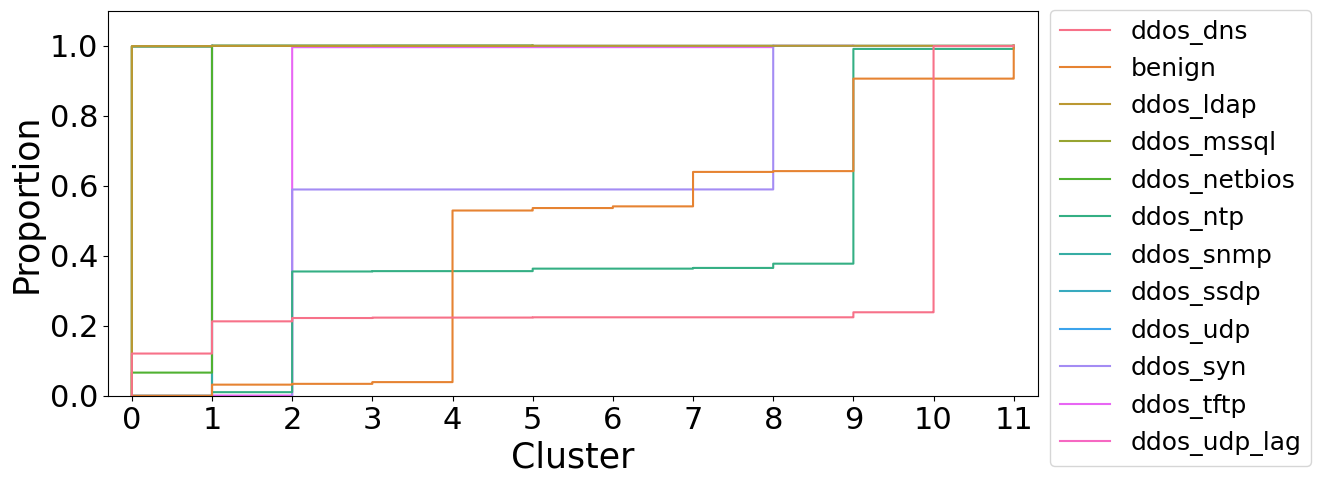

In [5]:
plt.figure(figsize=(12,5))
ax = sns.ecdfplot(data=labels, x='cl_labels12', hue='gt_labels')
plt.xlabel("Cluster", fontsize=25)
plt.ylabel("Proportion", fontsize=25)
sns.move_legend(ax, bbox_to_anchor=(1, 1.035), loc="upper left", title=None, fontsize=18)
plt.tick_params(labelsize=22)
plt.xticks(range(0,12,1))
plt.xlim(-0.3,11.3)
plt.ylim(0,1.1)
plt.show()

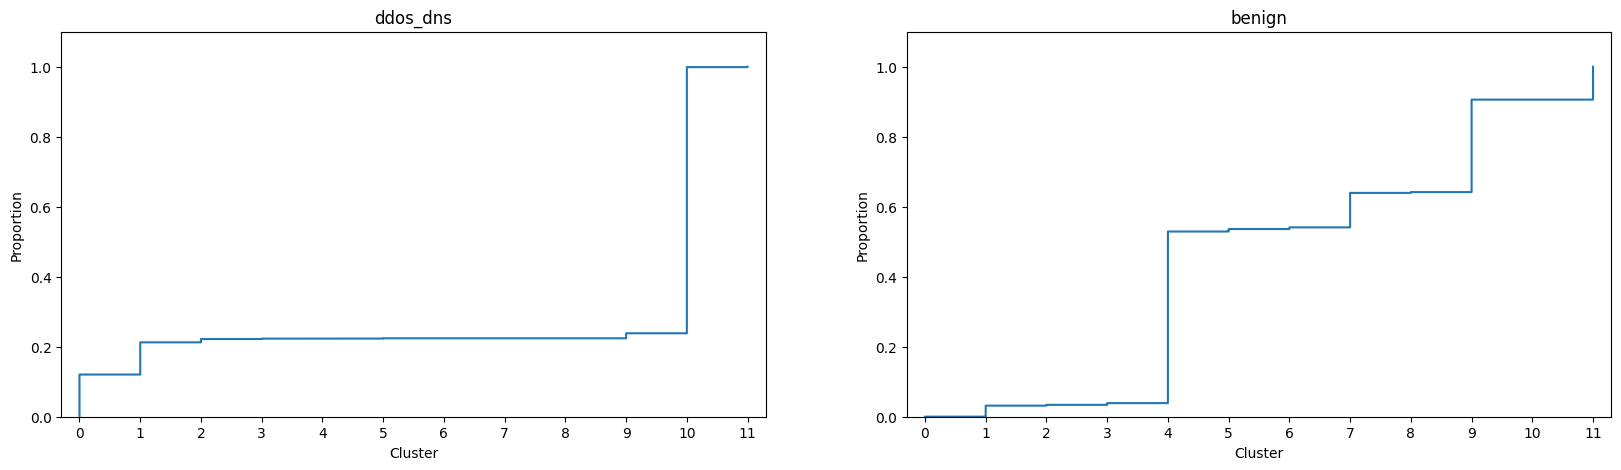

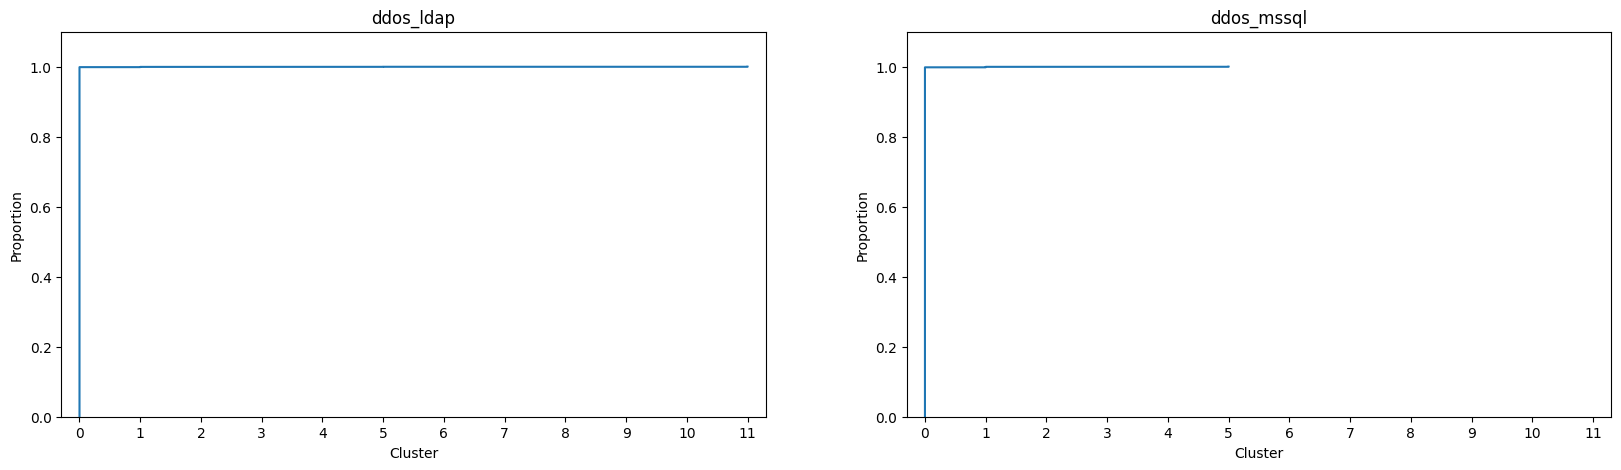

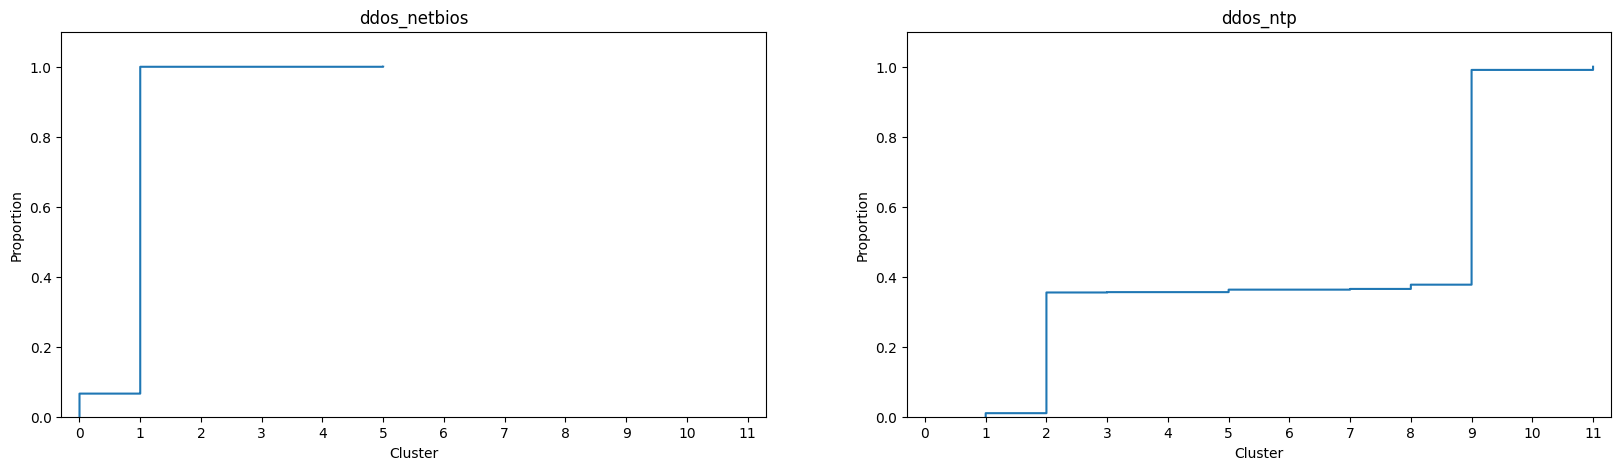

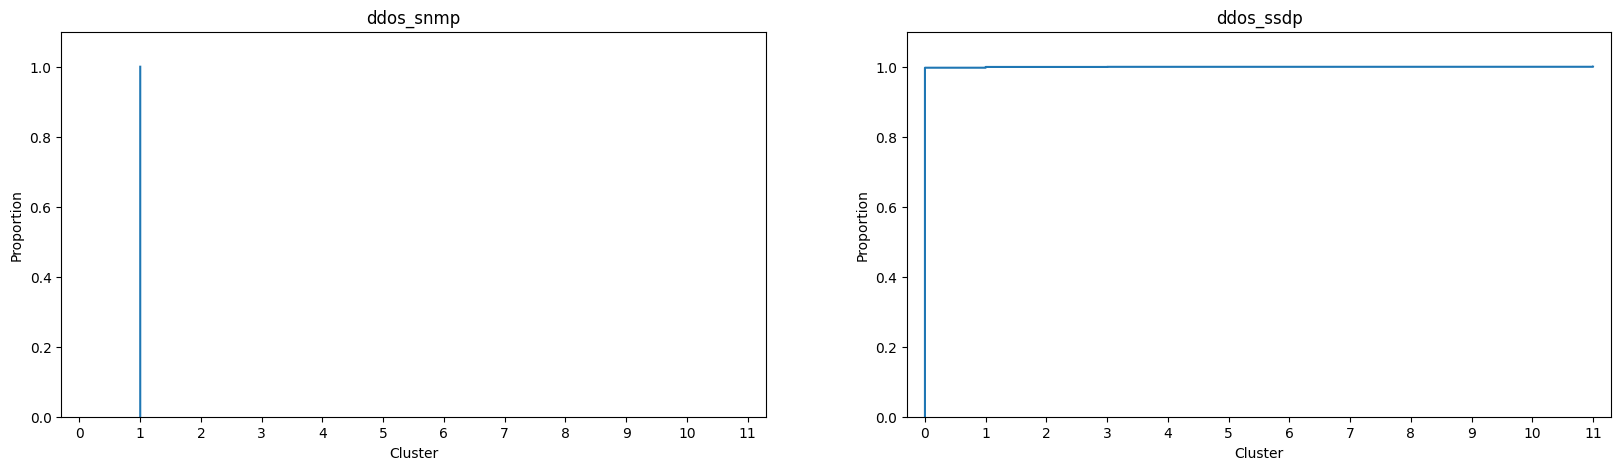

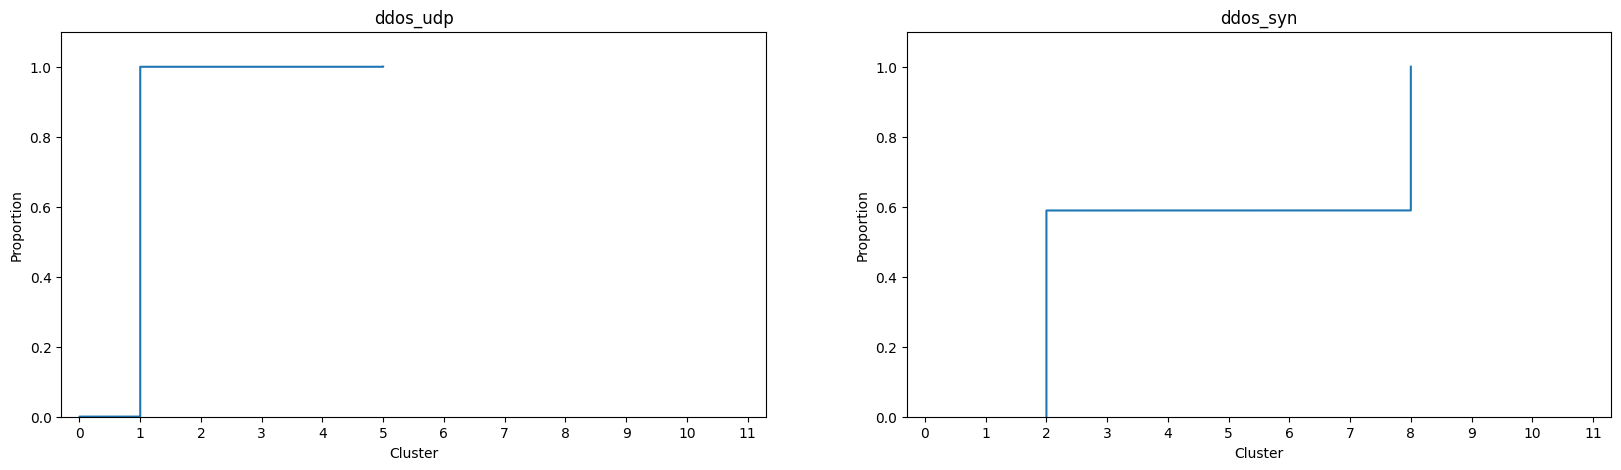

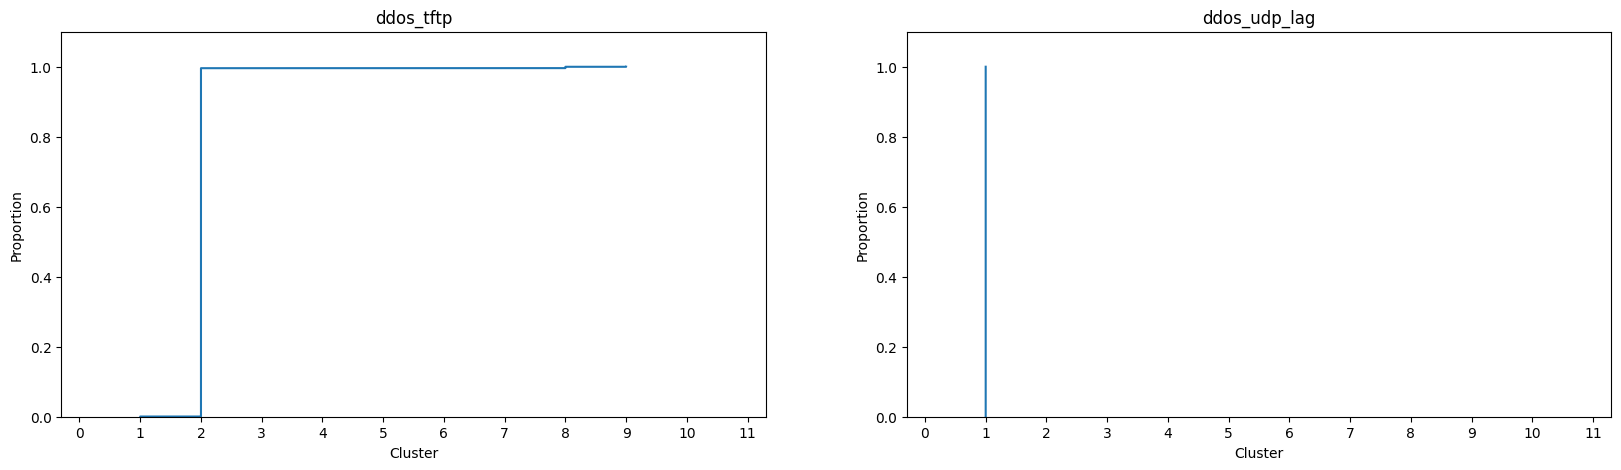

In [6]:
gt_labels = labels['gt_labels'].unique()
for i in range(0, len(gt_labels), 2):
    fig, axes = plt.subplots(1, 2, figsize=(20,5))
    sns.ecdfplot(data=labels[labels['gt_labels']==gt_labels[i]], x = 'cl_labels12', ax = axes[0])
    axes[0].set_xlabel("Cluster")
    axes[0].set_ylabel("Proportion")
    axes[0].set_title(gt_labels[i])
    axes[0].set_xticks(range(0,12,1))
    axes[0].set_xlim(-0.3,11.3)
    axes[0].set_ylim(0,1.1)

    sns.ecdfplot(data=labels[labels['gt_labels']==gt_labels[i+1]], x = 'cl_labels12', ax = axes[1])
    axes[1].set_xlabel("Cluster")
    axes[1].set_ylabel("Proportion")
    axes[1].set_title(gt_labels[i+1])
    axes[1].set_xticks(range(0,12,1))
    axes[1].set_xlim(-0.3,11.3)
    axes[1].set_ylim(0,1.1)
    plt.show()

Labels -> clusters
- ddos_dns: clusters 0, 1, and 10 (mainly)
- benign: clusters 1, 4, 7, 9, 11
- ddos_ldap: cluster 0
- ddos_mssql: cluster 0
- ddos_netbios: cluster 1 (mainly)
- ddos_ntp: clusters 2, 9
- ddos_snmp: cluster 1
- ddos_ssdp: cluster 0
- ddos_udp: cluster 1
- ddos_syn: clusters 2, 8
- ddos_tftp: cluster 2
- ddos_udp_lag: cluster 1

Hence, some classes are represented by only one cluster (e.g. ddos_ldap, ddos_mssql, ddos_netbios, ddos_snmp, ddos_ssdp, ddos_udp, ddos_udp_lag, ddos_tftp), while others are scattered among many of them (benign, ddos_dns). Some clusters contain different classes, reflecting the groups we already discussed in the previous sections: these attacks have similar characteristics, making it difficult for the models to discern them. In fact, also supervised machine learning models struggled to correctly classify them. For example, in cluster 0 we have ddos_ldap, ddos_mssql and ddos_ssdp samples, in cluster 1 ddos_netbios, ddos_snmp, ddos_udp and ddos_udp_lag, and in cluster 2 ddos_ntp, ddos_syn and ddos_tftp. Moreover, we can notice that the benign traffic is scattered between several clusters, meaning that it has similar patterns with malicious traffic: in particular, it is classified in cluster 1 with ddos_netbios, ddos_snmp, ddos_udp and ddos_udp_lag, and in 9 with ddos_ntp. Clusters 4, 7 and 11 are composed only by benign traffic. Since some attacks are divided into more clusters more or less equally, we can identify them as subattacks. In particular, ddos_ntp is classified in clusters 2 and 9, while ddos_syn in 2 and 8. This means that a part of their traffic is somehow similar (and also to ddos_tftp), while another is not. The 80% of the ddos_dns traffic is in cluster 10, meaning that probably there aren't sub-attacks, but only some outliers that have been classified differently.

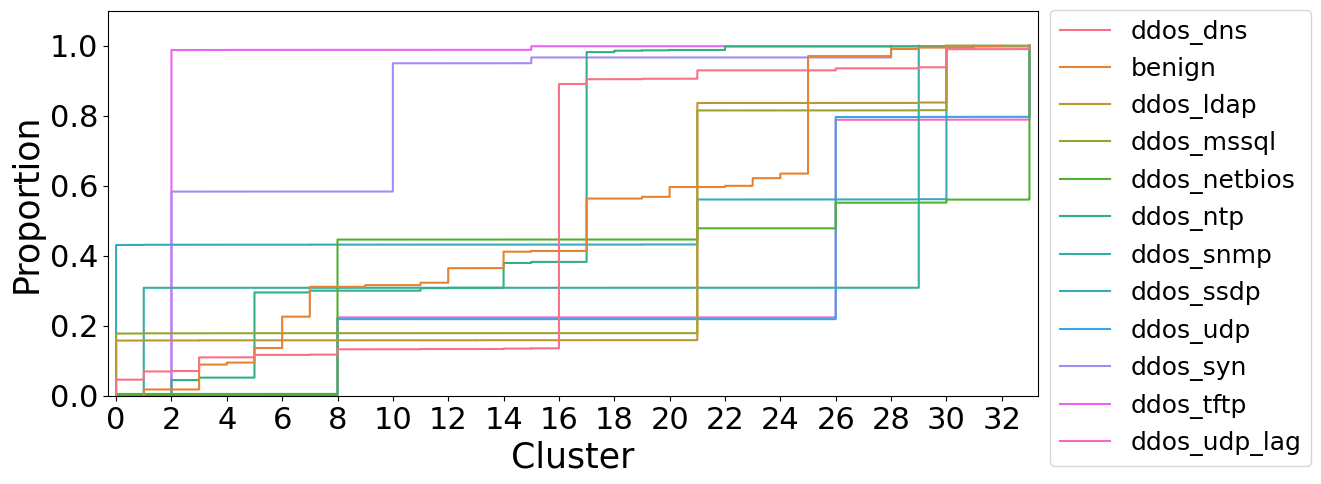

In [7]:
plt.figure(figsize=(12,5))
ax = sns.ecdfplot(data=labels, x='cl_labels34', hue='gt_labels')
plt.xlabel("Cluster", fontsize=25)
plt.ylabel("Proportion", fontsize=25)
sns.move_legend(ax, bbox_to_anchor=(1, 1.035), loc="upper left", title=None, fontsize=18)
plt.tick_params(labelsize=22)
plt.xticks(range(0,34,2))
plt.xlim(-0.3,33.3)
plt.ylim(0,1.1)
plt.show()

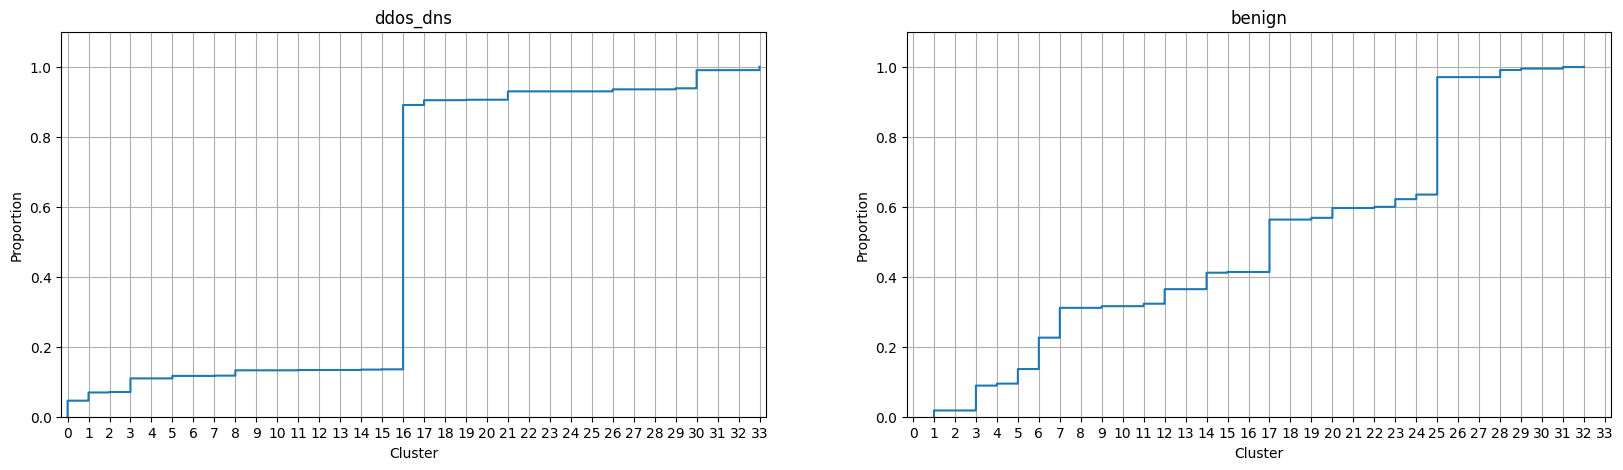

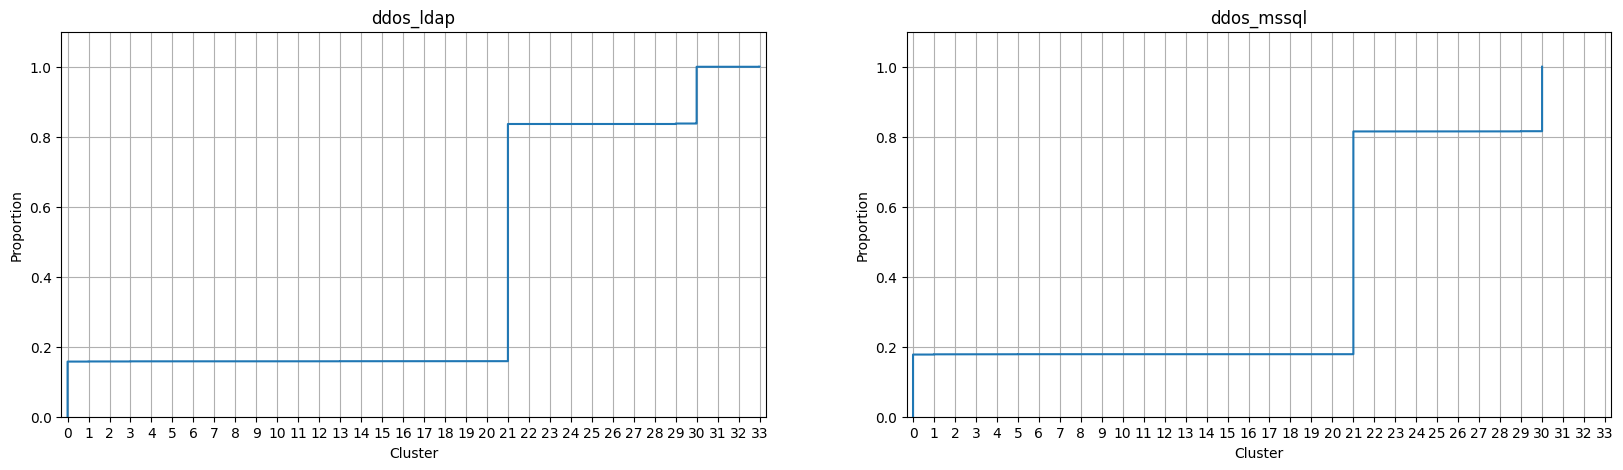

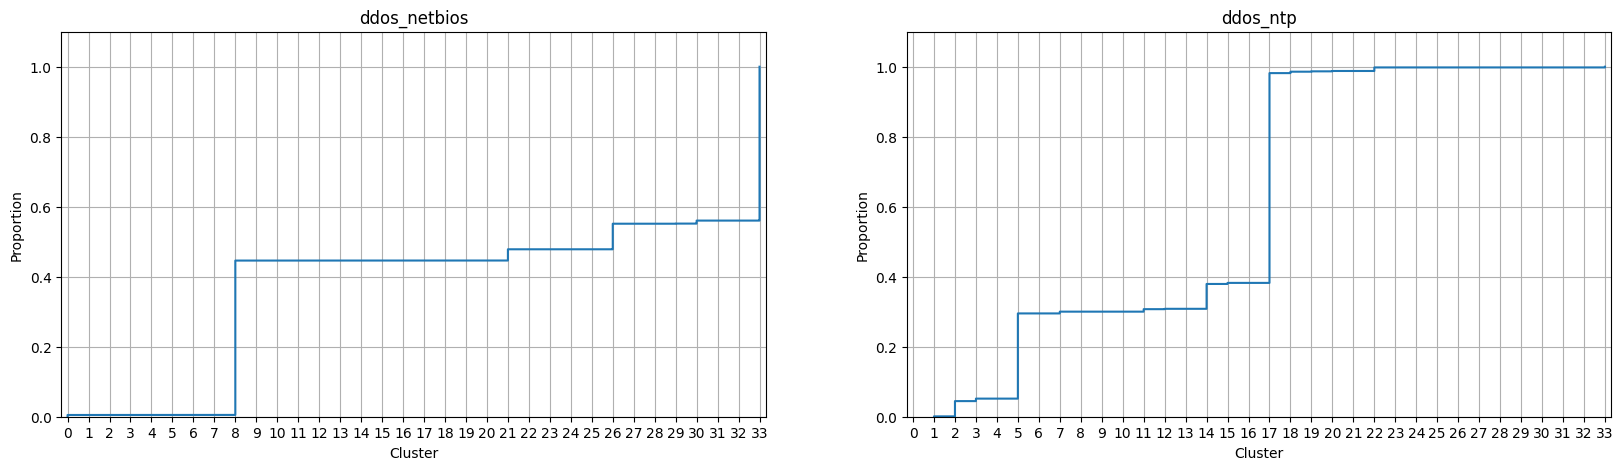

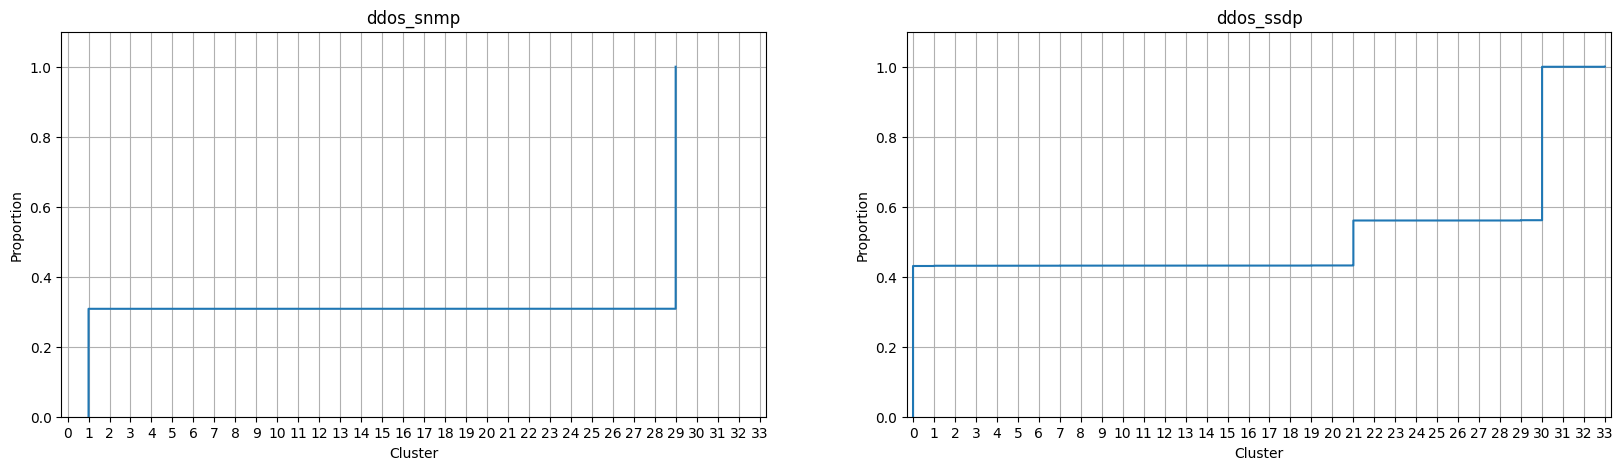

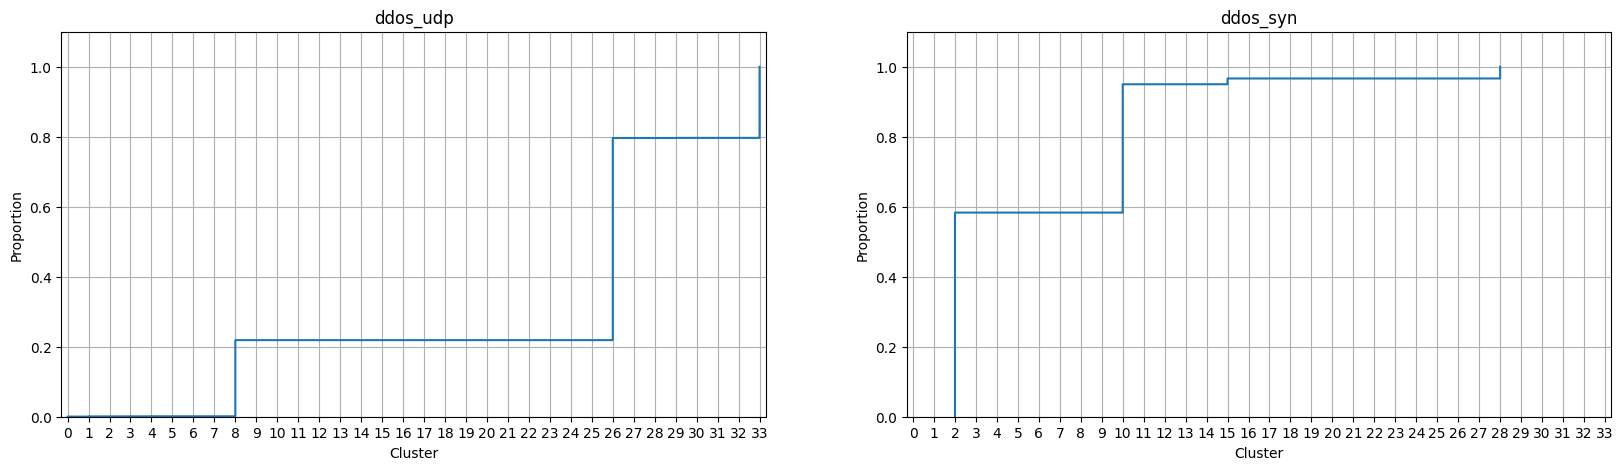

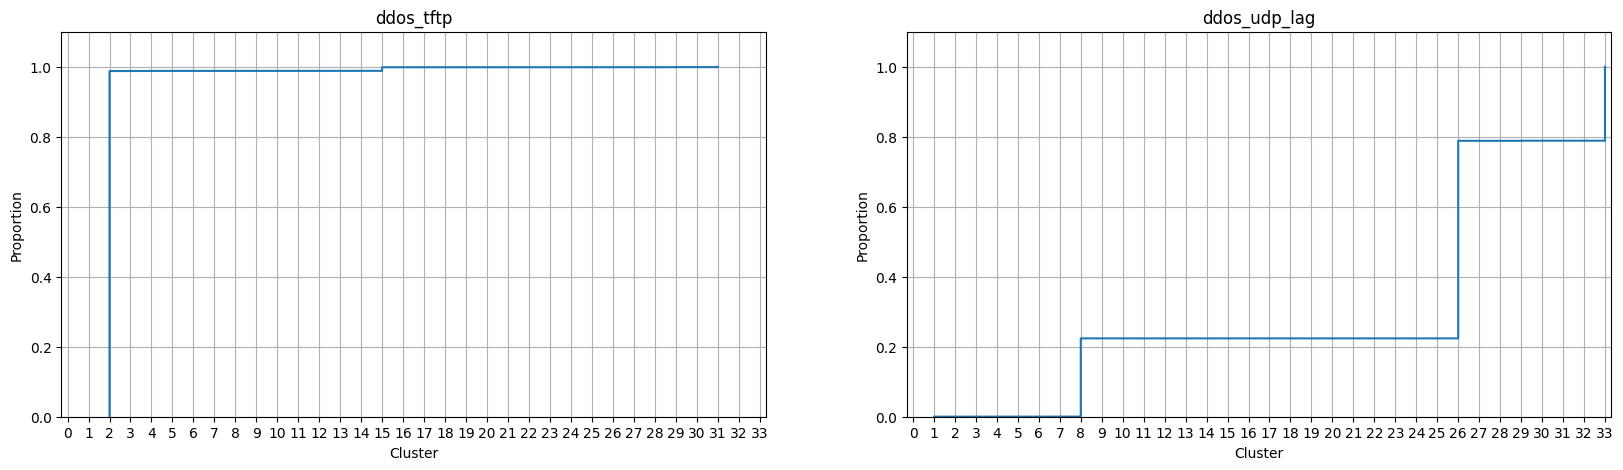

In [8]:
gt_labels = labels['gt_labels'].unique()
for i in range(0, len(gt_labels), 2):
    fig, axes = plt.subplots(1, 2, figsize=(20,5))
    sns.ecdfplot(data=labels[labels['gt_labels']==gt_labels[i]], x = 'cl_labels34', ax = axes[0])
    axes[0].set_xlabel("Cluster")
    axes[0].set_ylabel("Proportion")
    axes[0].set_title(gt_labels[i])
    axes[0].set_xticks(range(0,34,1))
    axes[0].set_xlim(-0.3,33.3)
    axes[0].set_ylim(0,1.1)
    axes[0].grid()

    sns.ecdfplot(data=labels[labels['gt_labels']==gt_labels[i+1]], x = 'cl_labels34', ax = axes[1])
    axes[1].set_xlabel("Cluster")
    axes[1].set_ylabel("Proportion")
    axes[1].set_title(gt_labels[i+1])
    axes[1].set_xticks(range(0,34,1))
    axes[1].set_xlim(-0.3,33.3)
    axes[1].set_ylim(0,1.1)
    axes[1].grid()
    plt.show()

Labels -> clusters
- ddos_dns: clusters 16 (75%), the rest is distributed among different clusters
- benign: cluster 25 (30%), the rest is scattered among all clusters
- ddos_ldap: cluster 0, 21, 30
- ddos_mssql: cluster 0, 21, 30
- ddos_netbios: cluster 8, 33 (mainly)
- ddos_ntp: clusters 5, 17
- ddos_snmp: cluster 1, 29
- ddos_ssdp: cluster 0, 21, 30
- ddos_udp: clusters 8, 26, 33
- ddos_syn: clusters 2, 10
- ddos_tftp: clusters 2
- ddos_udp_lag: clusters 8, 26, 33

As highlighted before, the benign traffic is distributed among many clusters, which means that it contains multiple patterns and types of flows: cluster 25 contains the 30% of them and it is composed only by benign traffic, while cluster 17 contains the 10% and it is in common with ddos_ntp (meaning that some flows of benign traffic resemble ddos_ntp ones). Then, we can notice that the groups we identified before are again scattered among the same clusters: 
- ddos_udp and ddos_udp_lag -> clusters 8, 26, 33
- ddos_ldap, ddos_mssql and ddos_ssdp -> cluster 0, 21, 30
- ddos_tftp, ddos_syn and ddos_ntp -> share cluster 2

Furthermore, it is evident that ddos_tftp does not present sub-attacks, since it is classified again only in one cluster. With 12 clusters ddos_udp and ddos_udp_lag and ddos_ldap, ddos_mssql and ddos_ssdp where classified only in 1 cluster, while now in 3 different ones, meaning that probably their traffic has some (small) different characteristics. Finally, ddos_snmp and ddos_syn flows are again scattered among two clusters, making it evident that they are composed by two sub-attacks each.

## Feature importance: permutation feature importance
Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature’s values, which breaks the relationship between the feature and the true outcome. We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, namely the model relied on that feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, namely the model ignored that feature for the prediction.

Again, we repeat the analysis for the two models presented above.

In [13]:
feature_names = df.drop(columns='label').columns

r12 = permutation_importance(kmeans12, X, None,
                           n_repeats=30,
                           random_state=0)


for i in r12.importances_mean.argsort()[::-1]:
    if r12.importances_mean[i] - 2 * r12.importances_std[i] > 0:
        print(f"{feature_names[i]:<8} "
              f"{r12.importances_mean[i]:.3f}"
              f" +/- {r12.importances_std[i]:.3f}")

Max Packet Length 118695.109 +/- 439.365
Fwd Packet Length Max 106380.424 +/- 391.344
Inbound  96002.723 +/- 391.843
Flow Bytes/s 86353.242 +/- 390.879
Bwd Packet Length Max 86303.229 +/- 520.147
Down/Up Ratio 80680.771 +/- 344.567
CWE Flag Count 79248.267 +/- 304.627
Source Port 71361.644 +/- 361.129
ACK Flag Count 69370.647 +/- 361.300
Bwd IAT Total 58756.208 +/- 481.112
Idle Min 53789.867 +/- 375.539
Bwd Packet Length Min 53556.828 +/- 271.475
act_data_pkt_fwd 49476.871 +/- 313.454
Fwd Packet Length Std 46703.882 +/- 283.317
Idle Std 40634.925 +/- 376.727
Fwd Packets/s 38915.478 +/- 279.393
Init_Win_bytes_forward 37767.966 +/- 262.759
Source IP 23188.671 +/- 173.528
Destination Port 17693.729 +/- 147.216
RST Flag Count 13735.180 +/- 309.117
Init_Win_bytes_backward 11478.064 +/- 156.058
protocol_0 9801.518 +/- 358.085
Active Max 7058.282 +/- 181.064
Bwd IAT Min 6904.883 +/- 109.542
Total Fwd Packets 5654.212 +/- 64.639
Bwd Packets/s 4585.566 +/- 80.338
SYN Flag Count 2936.355 +/- 139

In [14]:
r34 = permutation_importance(kmeans34, X, None,
                           n_repeats=30,
                           random_state=0)


for i in r34.importances_mean.argsort()[::-1]:
    if r34.importances_mean[i] - 2 * r34.importances_std[i] > 0:
        print(f"{feature_names[i]:<8} "
              f"{r34.importances_mean[i]:.3f}"
              f" +/- {r34.importances_std[i]:.3f}")

Max Packet Length 120770.728 +/- 443.726
Fwd Packet Length Max 112242.212 +/- 362.553
Inbound  90271.845 +/- 382.394
Down/Up Ratio 89713.775 +/- 373.592
Bwd Packet Length Max 85886.115 +/- 553.222
Flow Bytes/s 84505.556 +/- 336.872
CWE Flag Count 77230.305 +/- 307.626
Source Port 71655.984 +/- 345.421
ACK Flag Count 71302.295 +/- 348.318
Init_Win_bytes_forward 68674.065 +/- 347.385
Idle Min 67695.287 +/- 326.521
Fwd Packets/s 60100.663 +/- 313.921
Source IP 51352.076 +/- 451.015
Init_Win_bytes_backward 50649.593 +/- 325.552
Active Max 50467.159 +/- 246.665
Bwd IAT Total 44376.518 +/- 415.972
Idle Std 42534.249 +/- 392.378
act_data_pkt_fwd 42152.595 +/- 293.684
Bwd Packet Length Min 42052.365 +/- 279.576
Fwd Packet Length Std 41915.183 +/- 393.396
Active Min 35687.619 +/- 512.939
Total Fwd Packets 22557.744 +/- 123.928
Destination Port 19068.916 +/- 199.754
Bwd IAT Min 6639.323 +/- 385.153
RST Flag Count 6332.853 +/- 335.878
Bwd Packets/s 4005.986 +/- 413.562
SYN Flag Count 2546.682 +/-

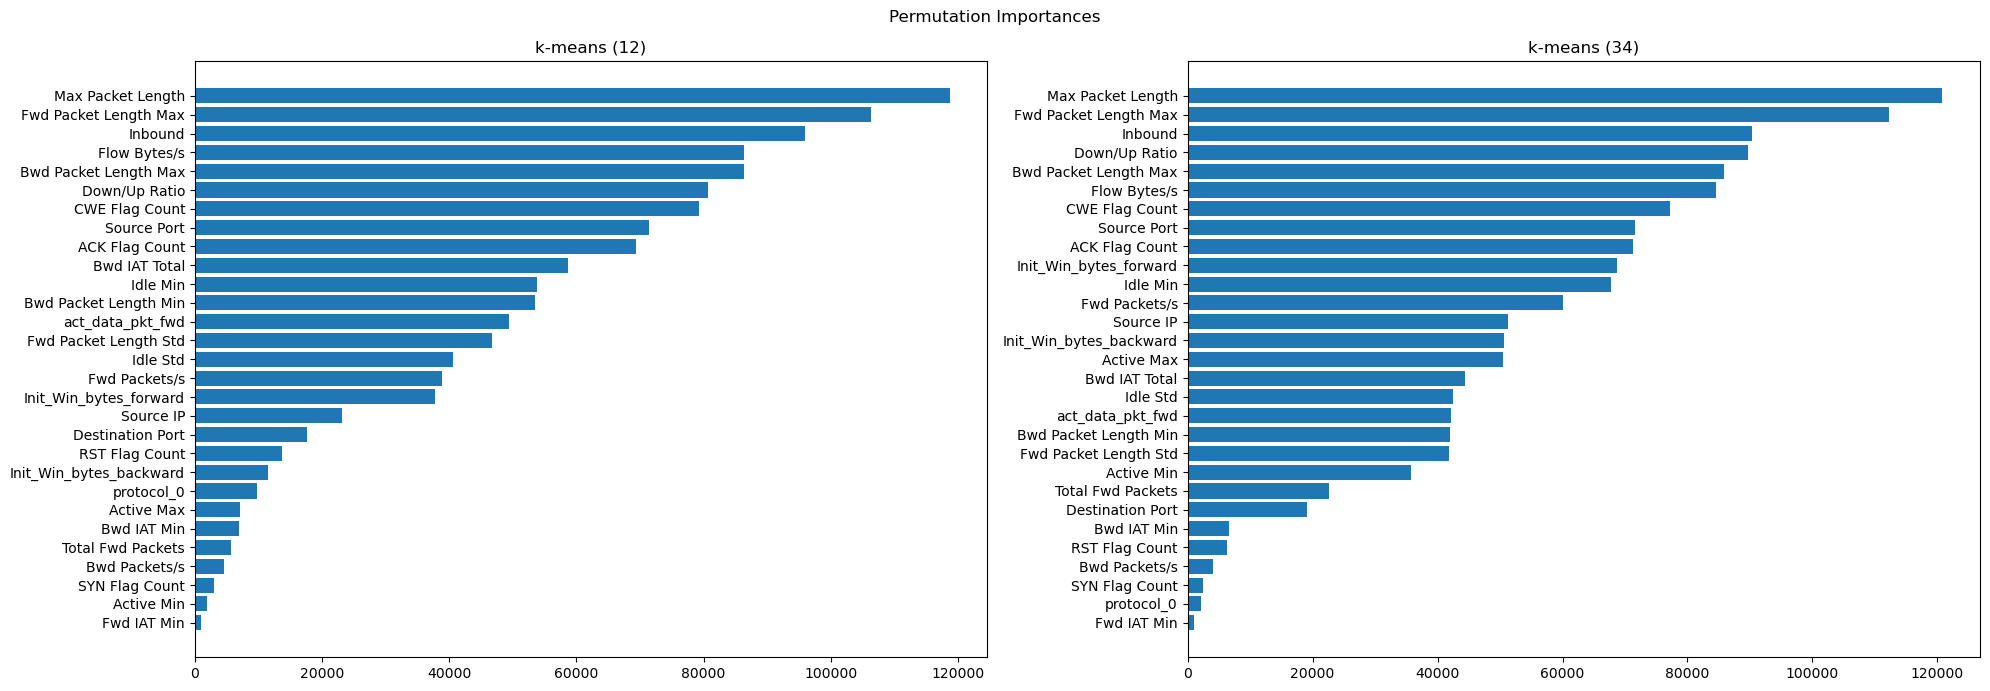

In [15]:
sorted_idx12 = r12.importances_mean.argsort()
sorted_idx34 = r34.importances_mean.argsort()

fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes[0].barh(feature_names[sorted_idx12], r12.importances[sorted_idx12].mean(axis=1).T)
axes[0].set_title("k-means (12)")
axes[1].barh(feature_names[sorted_idx34], r34.importances[sorted_idx34].mean(axis=1).T)
axes[1].set_title("k-means (34)")
plt.suptitle("Permutation Importances")
plt.tight_layout()
plt.show()

For both models, the three most important features are *Max Packet Length*, *Fwd Packet Length Max* and *Inbound*, while the least important are *Bwd Packet/s*, *Syn Flag Count* and *Fwd IAT Min*. There are also some differences, for example the second least important in one case is *Active Min*, while in the other case it is *protocol_0*.

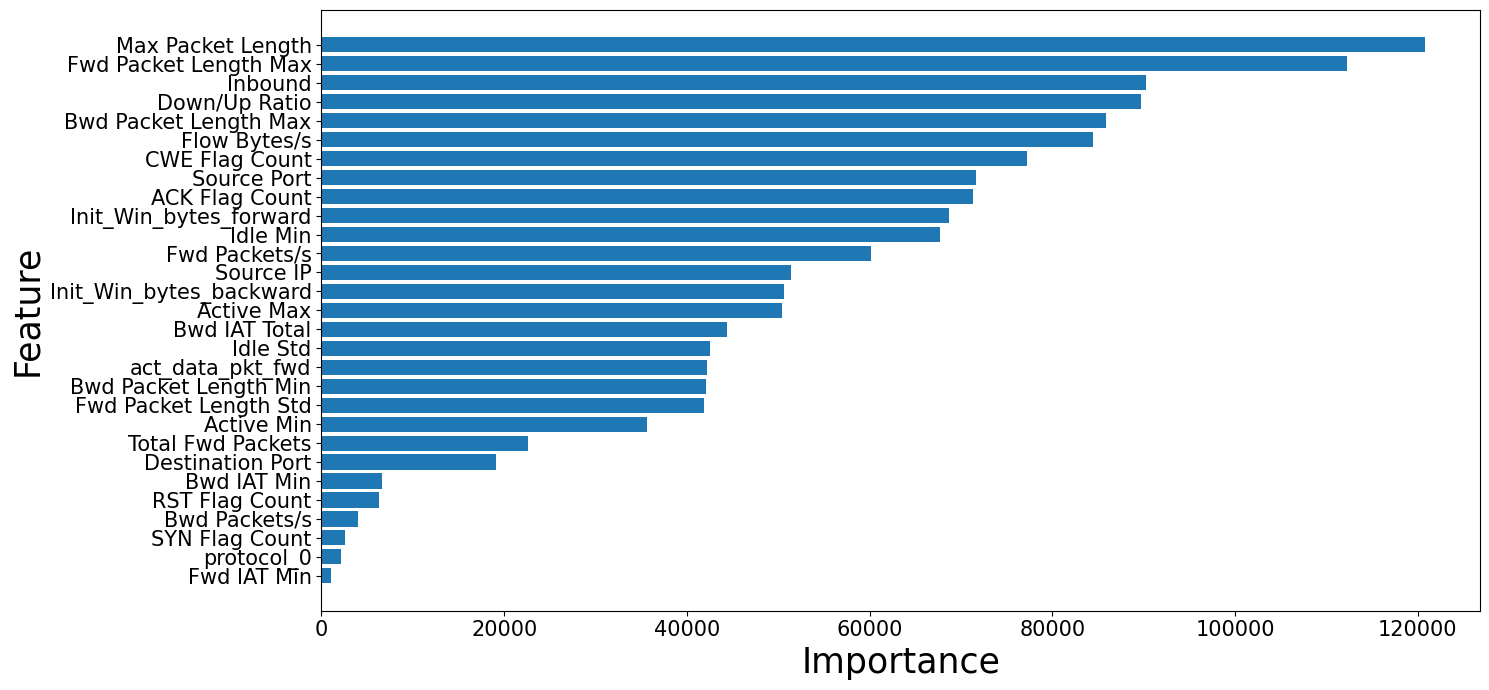

In [12]:
plt.figure(figsize=(15,7))
plt.barh(feature_names[sorted_idx34], r34.importances[sorted_idx34].mean(axis=1).T)
plt.tick_params(labelsize=15)
plt.ylabel("Feature", fontsize=25)
plt.xlabel("Importance", fontsize=25)
plt.tight_layout()
plt.show()

Even though we already performed dimensionality reduction during the preprocessing phase, there are still features with a correlation of 0.8 in our dataset. When features are collinear or highly correlated, permuting one feature has little effect on the models' performance because it can get the same information from a correlated feature. One way to handle them is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


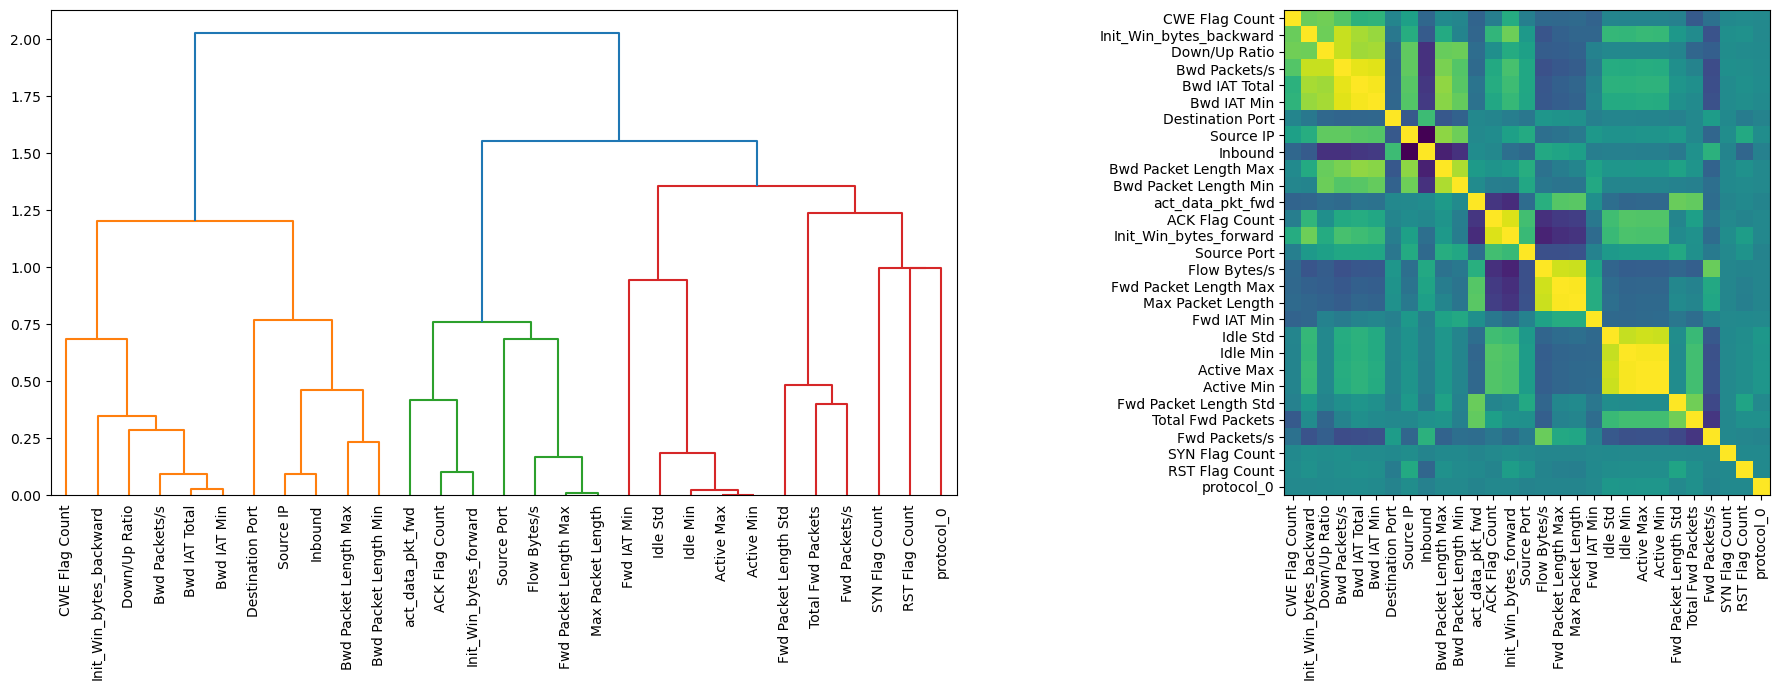

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = df.columns[selected_features]

In [14]:
cluster_features = pd.DataFrame()
cluster_features['feature'] = df.drop(columns='label').columns
cluster_features['cluster_id'] = cluster_ids
cluster_features.sort_values('cluster_id')

,feature,cluster_id
21,Init_Win_bytes_backward,1
19,Down/Up Ratio,1
18,CWE Flag Count,1
10,Bwd IAT Total,1
11,Bwd IAT Min,1
13,Bwd Packets/s,1
0,Source IP,2
2,Destination Port,2
6,Bwd Packet Length Max,2
7,Bwd Packet Length Min,2


We can notice that the first two most important features found above are clustered in the same group, meaning that they bring similar information.

Source Port 6450.484 +/- 90.874
Source IP 6095.604 +/- 217.157
Fwd Packet Length Max 2274.125 +/- 218.316
Destination Port 377.372 +/- 23.630
Total Fwd Packets 126.543 +/- 38.234


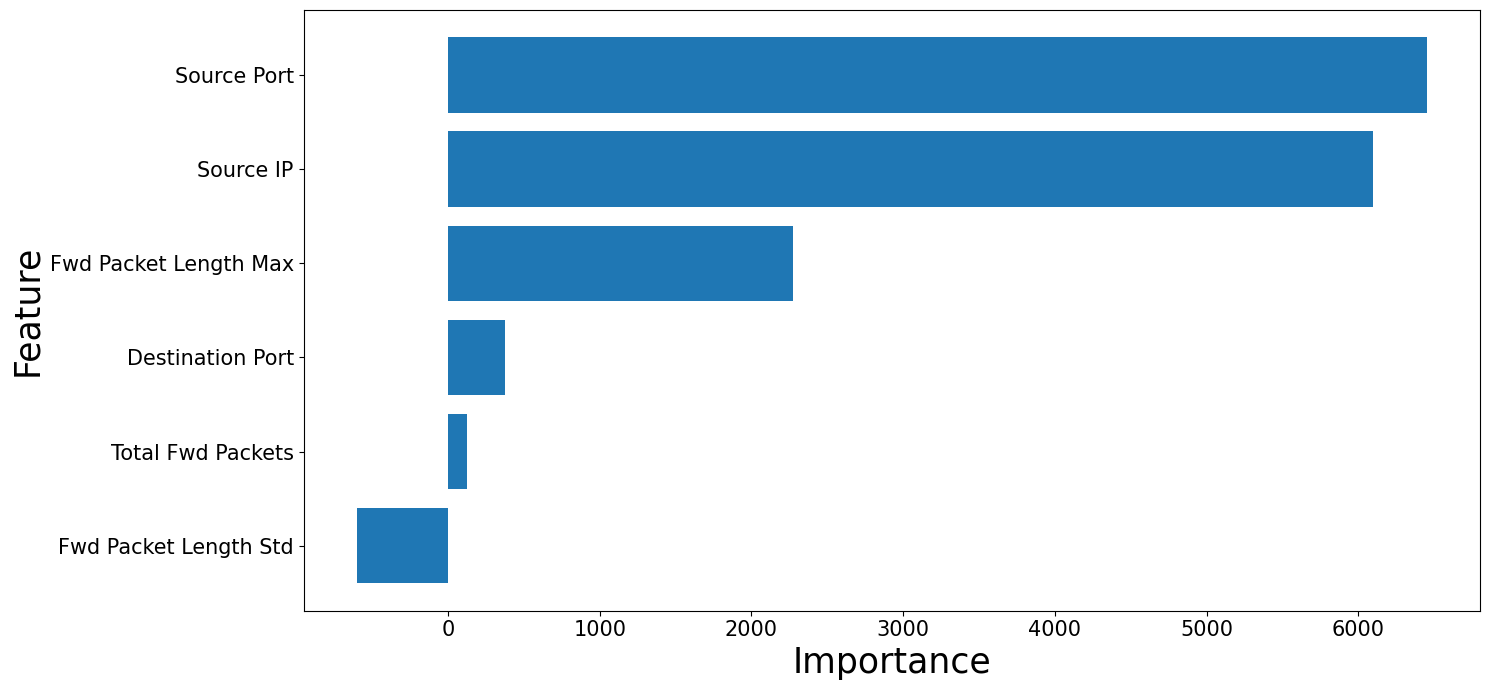

In [21]:
# Perform again permutation importance only on the selected features (one per cluster)
X_sel = df[selected_features_names].to_numpy()

cl_labels12_1 = kmeans12.fit_predict(X_sel) # Get clusters ID
r12_1 = permutation_importance(kmeans12, X_sel, None,
                           n_repeats=30,
                           random_state=0)

for i in r12_1.importances_mean.argsort()[::-1]:
    if r12_1.importances_mean[i] - 2 * r12_1.importances_std[i] > 0:
        print(f"{feature_names[i]:<8} "
              f"{r12_1.importances_mean[i]:.3f}"
              f" +/- {r12_1.importances_std[i]:.3f}")

sorted_idx121 = r12_1.importances_mean.argsort()
plt.figure(figsize=(15,7))
plt.barh(feature_names[sorted_idx121], r12_1.importances[sorted_idx121].mean(axis=1).T)
plt.tick_params(labelsize=15)
plt.ylabel("Feature", fontsize=25)
plt.xlabel("Importance", fontsize=25)
plt.tight_layout()
plt.show()

Source Port 3570.586 +/- 67.164
Source IP 3374.326 +/- 188.793
Fwd Packet Length Max 1835.172 +/- 186.123
Destination Port 828.969 +/- 25.345
Total Fwd Packets 326.402 +/- 51.020


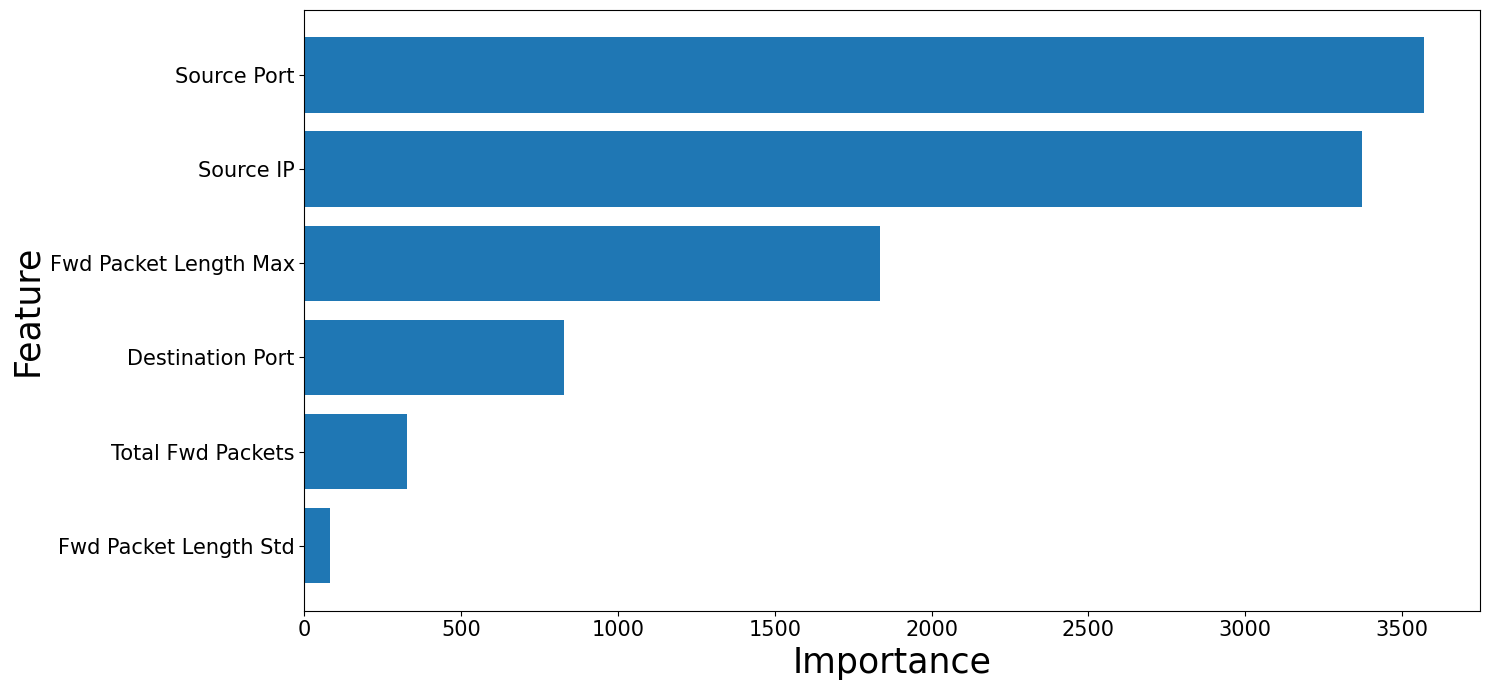

In [16]:
# Perform again permutation importance only on the selected features (one per cluster)
X_sel = df[selected_features_names].to_numpy()

cl_labels34_1 = kmeans34.fit_predict(X_sel) # Get clusters ID
r34_1 = permutation_importance(kmeans34, X_sel, None,
                           n_repeats=30,
                           random_state=0)

for i in r34_1.importances_mean.argsort()[::-1]:
    if r34_1.importances_mean[i] - 2 * r34_1.importances_std[i] > 0:
        print(f"{feature_names[i]:<8} "
              f"{r34_1.importances_mean[i]:.3f}"
              f" +/- {r34_1.importances_std[i]:.3f}")

sorted_idx121 = r34_1.importances_mean.argsort()
plt.figure(figsize=(15,7))
plt.barh(feature_names[sorted_idx121], r34_1.importances[sorted_idx121].mean(axis=1).T)
plt.tick_params(labelsize=15)
plt.ylabel("Feature", fontsize=25)
plt.xlabel("Importance", fontsize=25)
plt.tight_layout()
plt.show()

Using this technique, the most important features are *Source Port* and *Source IP*, while the *Fwd Packet Length Max*, that before was really relevant, has a middle importance. The least important is the *Fwd Packet Length Std*.

## Attack pattern investigation
Above we highlighted how some attacks might contain some sub-attacks, for example *ddos_syn* and *ddos_ntp*.

In [17]:
df_with34label = df.copy()
df_with34label['cluster34'] = cl_labels34
df_described34 = df_with34label.drop(columns='label').groupby('cluster34').mean()
df_described34

,Source IP,Source Port,Destination Port,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Fwd IAT Min,Bwd IAT Total,Bwd IAT Min,Fwd Packets/s,Bwd Packets/s,Max Packet Length,SYN Flag Count,RST Flag Count,ACK Flag Count,CWE Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,Active Max,Active Min,Idle Std,Idle Min,Inbound,protocol_0
cluster34,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.036507,-0.955511,0.926448,-0.036328,1.440138,-0.172277,-0.069596,-0.146261,0.441427,-0.014008,-0.112384,-0.113608,-0.235601,-0.044977,0.880438,-0.024329,-0.096031,-0.485071,-0.189020,-0.265523,-0.266314,-0.102881,-0.265014,-0.044084,-0.037205,-0.165955,-0.193486,0.295752,-0.030062
1,-0.019525,-0.991151,0.126150,-0.033457,-0.651819,-0.170793,-0.069596,-0.146261,-0.640965,-0.013960,-0.112384,-0.113294,-0.527710,-0.044679,-0.456212,-0.024329,-0.096031,-0.485071,-0.189020,-0.265523,-0.262994,-0.102881,-0.238538,-0.044059,-0.037147,-0.165955,-0.192406,0.295752,-0.030062
2,-0.036507,0.948742,0.110876,-0.035577,-1.047880,-0.170752,-0.068812,-0.146261,-0.766935,-0.014008,-0.109258,-0.070075,0.261630,0.044789,-0.708920,-0.024329,-0.096031,2.061553,-0.189020,-0.057070,0.426349,-0.102798,-0.286638,-0.042374,-0.035823,-0.158269,0.123485,0.295752,-0.030062
3,1.464073,0.550521,-0.888713,-0.031283,-0.644447,0.326544,0.365067,0.515014,-0.579889,-0.014021,0.073616,0.269312,-0.617866,-0.043684,-0.170848,-0.024329,-0.096031,-0.135774,-0.189020,0.633399,-0.048362,-0.069214,-0.239637,0.004130,0.042670,-0.159751,-0.034914,-3.381206,-0.030062
4,0.550063,0.934022,-1.492205,0.025912,-1.018199,-0.172277,-0.069596,-0.146261,-0.766935,0.567407,1.876128,0.396978,-1.151780,-0.044952,-0.690309,-0.024329,-0.096031,1.761950,-0.189020,8.944025,2.938537,12.356778,-0.279909,19.833715,38.540999,0.015357,1.541386,-3.164914,1.928479
5,0.651137,0.886537,-1.490348,-0.003258,-0.241742,3.500315,1.797257,-0.146261,-0.766916,0.030645,0.348080,0.425093,-1.145387,-0.030605,0.828544,-0.024329,-0.096031,1.982434,-0.114542,0.411394,6.802811,-0.008745,-0.158474,0.020309,0.041366,-0.164285,-0.040824,-1.389223,-0.030062
6,-8.524886,-1.010731,1.092659,-0.037844,-1.034815,-0.129011,-0.069499,-0.146261,-0.766202,0.104462,-0.112383,0.595105,-1.090894,0.377606,-0.700846,-0.024329,0.256351,-0.485071,4.836517,3.538910,0.158808,0.409635,-0.283747,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
7,0.940870,0.958570,-1.185287,-0.033783,-0.942755,0.466861,-0.061359,0.003295,-0.738851,0.179879,-0.095573,0.006647,-0.148263,-0.040763,-0.640943,-0.024329,10.413266,-0.485071,0.088843,-0.028404,0.776562,0.006447,-0.262975,-0.036716,-0.021386,-0.165856,0.209590,-2.985914,-0.030062
8,-0.036507,0.775146,0.917166,-0.036372,-0.242731,-0.172277,-0.069596,-0.146261,0.117789,-0.014033,-0.112384,-0.113608,0.945067,-0.044977,-0.194826,-0.024329,-0.096031,-0.485071,-0.189020,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062


In [18]:
# Find the most diverse features between two clusters
def most_diverse_feature(cluster1, cluster2):
    most_diverse = abs(df_with34label.drop(columns=['label']).loc[[cluster1, cluster2]].diff().dropna().squeeze(axis=0))
    return list(most_diverse.sort_values(ascending=False).index[0:3])

print("Most diverse features among two clusters containing the same label:")
print(f"ddos_snmp - clusters 1, 29 - {most_diverse_feature(1, 29)}")
print(f"ddos_syn - clusters 2, 10 - {most_diverse_feature(2, 10)}")
print(f"ddos_ntp - clusters 5, 17 - {most_diverse_feature(5, 17)}")
print(f"ddos_netbios/ddos_udp/ddos_udp_lag - clusters 8, 33 - {most_diverse_feature(8, 33)}")
print(f"ddos_udp/ddos_udp_lag - clusters 8, 26 - {most_diverse_feature(8, 26)}")
print(f"ddos_udp/ddos_udp_lag - clusters 26, 33 - {most_diverse_feature(26, 33)}")
print(f"ddos_ldap/ddos_mssql/ddos_ssdp - clusters 0, 21 - {most_diverse_feature(0, 21)}")
print(f"ddos_ldap/ddos_mssql/ddos_ssdp - clusters 0, 30 - {most_diverse_feature(0, 30)}")
print(f"ddos_ldap/ddos_mssql/ddos_ssdp - clusters 21, 30 - {most_diverse_feature(21, 30)}")

Most diverse features among two clusters containing the same label:
ddos_snmp - clusters 1, 29 - ['cluster34', 'act_data_pkt_fwd', 'Inbound']
ddos_syn - clusters 2, 10 - ['Destination Port', 'Fwd Packets/s', 'Flow Bytes/s']
ddos_ntp - clusters 5, 17 - ['protocol_0', 'Bwd IAT Total', 'Active Max']
ddos_netbios/ddos_udp/ddos_udp_lag - clusters 8, 33 - ['Destination Port', 'Fwd Packets/s', 'Flow Bytes/s']
ddos_udp/ddos_udp_lag - clusters 8, 26 - ['Destination Port', 'Fwd Packets/s', 'Flow Bytes/s']
ddos_udp/ddos_udp_lag - clusters 26, 33 - ['Destination Port', 'Fwd Packets/s', 'Flow Bytes/s']
ddos_ldap/ddos_mssql/ddos_ssdp - clusters 0, 21 - ['Destination Port', 'act_data_pkt_fwd', 'Total Fwd Packets']
ddos_ldap/ddos_mssql/ddos_ssdp - clusters 0, 30 - ['act_data_pkt_fwd', 'Destination Port', 'Total Fwd Packets']
ddos_ldap/ddos_mssql/ddos_ssdp - clusters 21, 30 - ['Destination Port', 'Fwd Packets/s', 'Flow Bytes/s']


We can notice that in the majority of the cases among the most discriminative features are *Fwd Packets/s*, *Flow Bytes/s* and *Destination Port*. This means that the different sub-attacks have different values for those features, so they are classified into different clusters. On the other hand, the attacks clustered together have similar values for those features.

In [19]:
df_with34label_gr = df_with34label.groupby(['cluster34', 'label']).mean().reset_index()
df_with34label_gr

,cluster34,label,Source IP,Source Port,Destination Port,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Fwd IAT Min,Bwd IAT Total,Bwd IAT Min,Fwd Packets/s,Bwd Packets/s,Max Packet Length,SYN Flag Count,RST Flag Count,ACK Flag Count,CWE Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,Active Max,Active Min,Idle Std,Idle Min,Inbound,protocol_0
0,0,ddos_dns,-0.036507,-0.467275,0.930764,-0.035651,1.423238,-0.172277,-0.069596,-0.146261,0.162734,-0.014025,-0.112384,-0.113608,-0.438988,-0.044977,0.869639,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.258321,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
1,0,ddos_ldap,-0.036507,-0.986276,0.947864,-0.036372,1.454955,-0.172277,-0.069596,-0.146261,0.403830,-0.013986,-0.112384,-0.113608,-0.269308,-0.044977,0.889905,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
2,0,ddos_mssql,-0.036507,-0.990589,0.919311,-0.036347,1.451650,-0.172277,-0.069596,-0.146261,0.381840,-0.013984,-0.112384,-0.113608,-0.284419,-0.044977,0.887793,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265203,-0.044084,-0.037205,-0.165955,-0.188459,0.295752,-0.030062
3,0,ddos_netbios,-0.036507,0.407348,0.768572,-0.036372,1.311351,-0.172277,-0.069596,-0.146261,0.560369,-0.014029,-0.112384,-0.113608,-0.091236,-0.044977,0.798150,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
4,0,ddos_ssdp,-0.036507,-0.992065,0.922576,-0.036369,1.433281,-0.172277,-0.069596,-0.146261,0.504640,-0.014024,-0.112384,-0.113608,-0.185736,-0.044977,0.876057,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265414,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,33,ddos_netbios,-0.036507,0.612915,-0.708283,-0.036372,-0.138189,-0.172277,-0.069596,-0.146261,0.242049,-0.014033,-0.112384,-0.113608,0.947483,-0.044977,-0.128030,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
122,33,ddos_ntp,-0.036507,1.627996,-1.260835,-0.036372,-0.332930,-0.172277,-0.069596,-0.146261,-0.486342,-0.014026,-0.112384,-0.113608,-0.412459,-0.044977,-0.252459,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
123,33,ddos_ssdp,-0.036507,0.331225,-1.501548,-0.036372,-0.892956,-0.172277,-0.069596,-0.146261,-0.705995,-0.014026,-0.112384,-0.113608,-0.412459,-0.044977,-0.610286,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062
124,33,ddos_udp,-0.036507,0.916353,-0.685026,-0.036372,-0.388993,-0.172277,-0.069596,-0.146261,-0.016763,-0.014033,-0.112384,-0.113608,0.992870,-0.044977,-0.288280,-0.024329,-0.096031,-0.485071,-0.18902,-0.265523,-0.266314,-0.102881,-0.265447,-0.044084,-0.037205,-0.165955,-0.194882,0.295752,-0.030062


In [20]:
# Find the most diverse features between two classes in the same cluster
def most_diverse_feature_cluster(cluster, label1, label2):
    most_diverse = abs(df_with34label_gr.loc[(df_with34label_gr['cluster34']==cluster) & ((df_with34label_gr['label']==label1) | (df_with34label_gr['label']==label2))].drop(columns=['cluster34', 'label']).diff().dropna().squeeze(axis=0))
    return most_diverse.sort_values(ascending=False)[0:3]

print("Most diverse features among two clusters containing the same label:")
print(f"ddos_udp/ddps_udp_lag - cluster 8 - \n{most_diverse_feature_cluster(8, 'ddos_udp', 'ddos_udp_lag')}\n")
print(f"ddos_udp/ddps_udp_lag - cluster 26 - \n{most_diverse_feature_cluster(26, 'ddos_udp', 'ddos_udp_lag')}\n")
print(f"ddos_udp/ddps_udp_lag - cluster 33 - \n{most_diverse_feature_cluster(33, 'ddos_udp', 'ddos_udp_lag')}\n")

print(f"ddos_ldap/ddos_mssql - cluster 0 - \n{most_diverse_feature_cluster(0, 'ddos_ldap', 'ddos_mssql')}\n")
print(f"ddos_ldap/ddos_mssql - cluster 21 - \n{most_diverse_feature_cluster(21, 'ddos_ldap', 'ddos_mssql')}\n")
print(f"ddos_ldap/ddos_mssql - cluster 30 - \n{most_diverse_feature_cluster(30, 'ddos_ldap', 'ddos_mssql')}\n")

print(f"ddos_ntp/benign - cluster 30 - \n{most_diverse_feature_cluster(17, 'ddos_ntp', 'benign')}\n")

Most diverse features among two clusters containing the same label:
ddos_udp/ddps_udp_lag - cluster 8 - 
Fwd Packets/s       0.129920
Flow Bytes/s        0.044266
Destination Port    0.022335
Name: 47, dtype: float64

ddos_udp/ddps_udp_lag - cluster 26 - 
Source Port              0.035391
Fwd Packet Length Std    0.020348
Destination Port         0.014981
Name: 96, dtype: float64

ddos_udp/ddps_udp_lag - cluster 33 - 
Fwd Packets/s    0.116339
Source Port      0.042615
Flow Bytes/s     0.039984
Name: 125, dtype: float64

ddos_ldap/ddos_mssql - cluster 0 - 
Destination Port    0.028554
Flow Bytes/s        0.021990
Fwd Packets/s       0.015111
Name: 2, dtype: float64

ddos_ldap/ddos_mssql - cluster 21 - 
Destination Port         0.026704
Flow Bytes/s             0.002385
Fwd Packet Length Max    0.002027
Name: 84, dtype: float64

ddos_ldap/ddos_mssql - cluster 30 - 
Flow Bytes/s        0.015581
Fwd Packets/s       0.008543
Destination Port    0.008236
Name: 112, dtype: float64

ddos_ntp/

The measures computed show that even the most different features have quite similar values among the confused classes, meaning that the model struggles to discern them. As above, we can notice that *Fwd Packets/s*, *Flow Bytes/s*, *Source Port* and *Destination Port* are the most different (but still too similar). Now we plot their ECDF to better visualize these similarities.

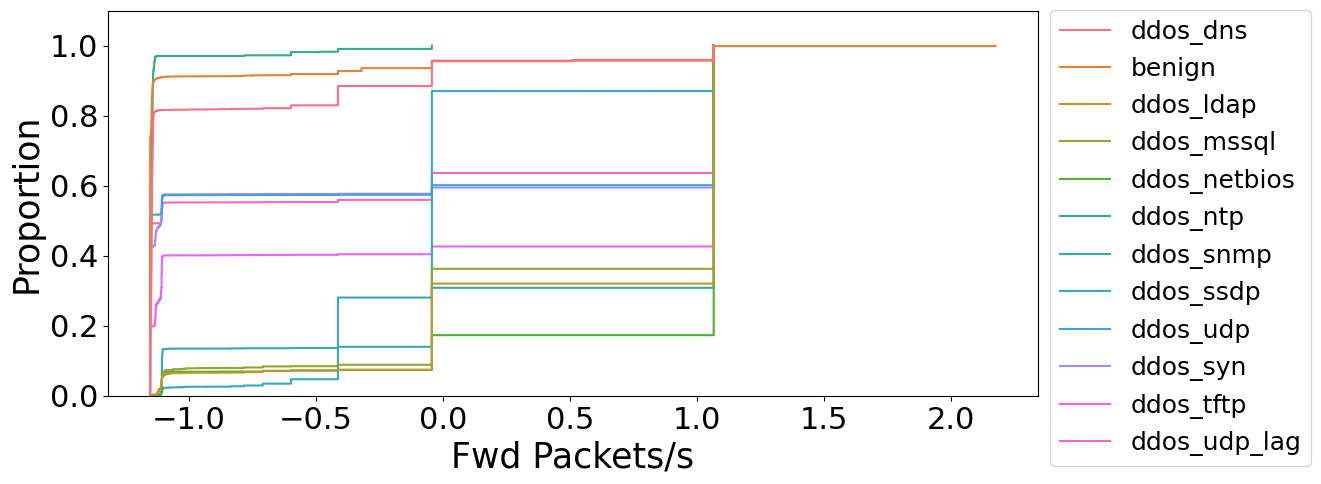

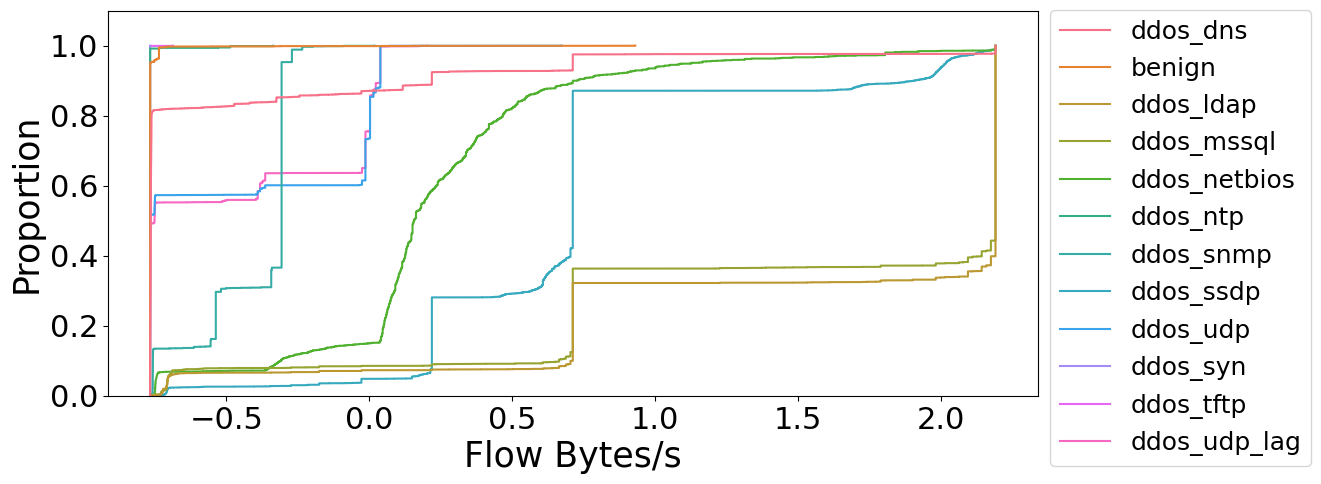

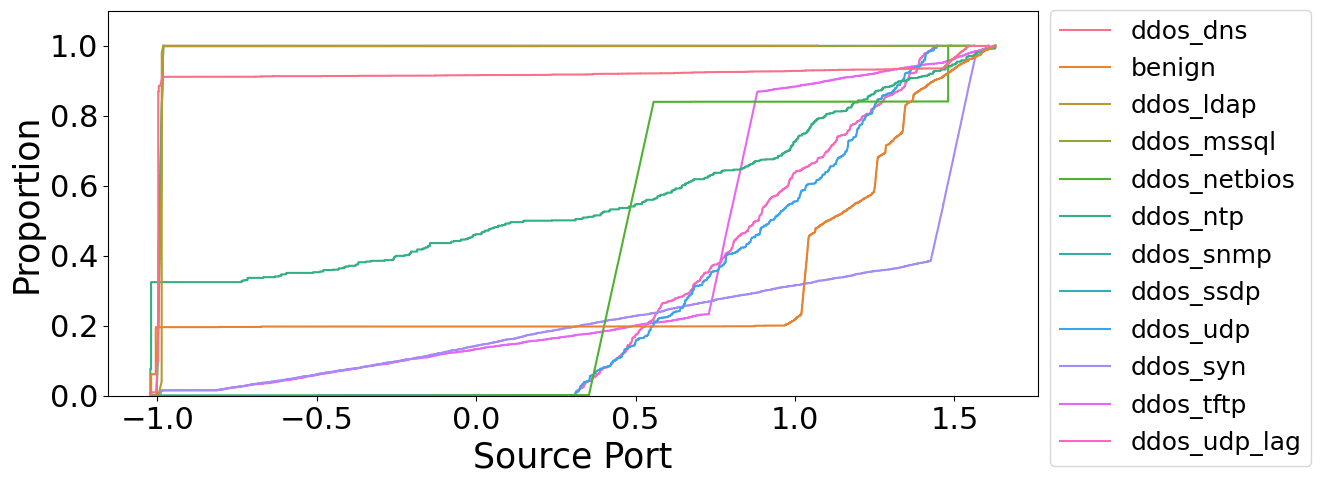

In [21]:
plt.figure(figsize=(12,5))
ax = sns.ecdfplot(data=df_with34label, x = "Fwd Packets/s", hue="label")
plt.xlabel("Fwd Packets/s", fontsize=25)
plt.ylabel("Proportion", fontsize=25)
sns.move_legend(ax, bbox_to_anchor=(1, 1.035), loc="upper left", title=None, fontsize=18)
plt.tick_params(labelsize=22)
plt.ylim(0,1.1)
plt.show()

plt.figure(figsize=(12,5))
ax = sns.ecdfplot(data=df_with34label, x = "Flow Bytes/s", hue="label")
plt.xlabel("Flow Bytes/s", fontsize=25)
plt.ylabel("Proportion", fontsize=25)
sns.move_legend(ax, bbox_to_anchor=(1, 1.035), loc="upper left", title=None, fontsize=18)
plt.tick_params(labelsize=22)
plt.ylim(0,1.1)
plt.show()

plt.figure(figsize=(12,5))
ax = sns.ecdfplot(data=df_with34label, x = "Source Port", hue="label")
plt.xlabel("Source Port", fontsize=25)
plt.ylabel("Proportion", fontsize=25)
sns.move_legend(ax, bbox_to_anchor=(1, 1.035), loc="upper left", title=None, fontsize=18)
plt.tick_params(labelsize=22)
plt.ylim(0,1.1)
plt.show()

It is evident that some attacks follow the same ECDF pattern (e.g., ddos_mssql and ddos_ldap, ddos_udp and ddos_udp_lag).

Similarities studied through their definitions or attack manners:
- ddos_ssdp, ddos_ldap, ddos_mssql: these three attacks are reflection-based. If the attacker can send a small command to the accomplices resulting in a large amount of traffic being sent to their victim, this is called “amplification”. Amplification is valuable to the attacker because they need fewer accomplices to overwhelm the victim. LDAP (a protocol for accessing and managing directory services over a network) can be abused by attackers in this way because there are many (small) LDAP commands that generate large reports. In this attack, the attacker uses LDAP injection to overload the directory server with malicious queries, causing it to crash or become unresponsive. MS-SQL Server Resolution Service can also be used in such a way when it is publicly accessible on the Internet. Under normal circumstances, the SSDP protocol is used to allow UPnP devices to broadcast their existence to other devices on the network: attackers act in order to make each device send a reply to the targeted victim with an amount of data up to about 30 times larger than the attacker’s request.
- ddos_udp, ddos_udp_lag: UDP based attacks. UDP flood attack is initiated on the remote host by sending numerous UDP packets. These UDP packets are sent to random ports on the target machine at a very high rate. As a result, the available bandwidth of the network gets exhausted, system crashes and performance degrade. The UDP-lag attack disrupts the connection between the client and the server. This attack is mostly used in online gaming where the players want to slow down / interrupt the movement of other players to outmaneuver them.
- ddos_syn: this attack overwhelms the target by sending a flood of SYN packets (part of the TCP handshake process), consuming resources without completing connections. Similarity with UDP flood: while SYN floods target TCP connections, they share the idea of overwhelming resources with high packet rates.
- ddos_netbios: this attack targets the NetBIOS protocol (which provides communication services on LANs), common in Windows environments, for service disruption. It can be defined as a service-specific attack, just like ddos_mssql, due to its primary goal of disrupting a specific service.

References:
- [Permutation feature importance](https://scikit-learn.org/1.5/modules/permutation_importance.html)
- [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/1.5/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)
- [permutation_importance](https://scikit-learn.org/1.5/modules/generated/sklearn.inspection.permutation_importance.html)
- [LDAP DDoS](https://www.cobalt.io/blog/introduction-to-ldap-injection-attack#:~:text=Denial%2Dof%2DService%20(DOS,to%20crash%20or%20become%20unresponsive.))
- [MSSQL DDoS](https://www.ncsc.gov.ie/emailsfrom/Shadowserver/DoS/MS-SQL/)
- [SSDP DDoS](https://www.cloudflare.com/it-it/learning/ddos/ssdp-ddos-attack/)
- [UDP DDoS](https://www.akamai.com/glossary/what-is-udp-flood-ddos-attack#:~:text=UDP%20flood%20is%20a%20type,require%20few%20resources%20to%20execute.)
- [UDP and UDP_LAG DDoS](https://www.unb.ca/cic/datasets/ddos-2019.html)